# Low-thrust transfers via indirect methods II (time)

In this notebook we show how to solve the **minimum time** Optimal Control Problem (OCP) for a low-thrust interplanetary transfer employing an indirect method.

Indirect methods are follow rather mechanic developments: starting from the dynamics a TPBVP (Two-Point-Boundary-Value-Problem) is built applying Pontryagin maximum (minimum, in our case) principle (PMP). The TPBVP is defined on an augmented ODE system and solved by means of single or multiple shooting methods.

In this notebook we guide, step-by-step, the reader in the application of such a method in a widely encountered case in space flight mechanics, the low-thrust minimum time problem. Eventually use `pykep` native tools to quickly skip the tedious parts.

We highlight the differences with respect to the developments presented in the [mass optimal (fixed time)](<./pontryagin_cartesian_mass.ipynb>) version of the very same indirect method.

In [1]:
import pykep as pk
import numpy as np
import heyoka as hy
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

## Manual construction of the TPBVP
We consider the dynamics of a spacecraft moving around a massive primary and equipped with a low-thrust propulsion system capable of delivering a constant thrust $T_{max}$:

$$
\left\{
\begin{array}{l}
\dot{\mathbf r}  = \mathbf v \\
\dot{\mathbf v} = -\frac{\mu}{r^3}\mathbf r + c_1 \frac um \hat{\mathbf i}\\
\dot{m} = - \frac{c_1}{c_2} u
\end{array}
\right.
$$
where $c_1=T_{max}$ is the maximum thrust that the spacecarft propulsion can deliver, while $c_2 = I_{sp} g_0$.

We introduce, following Pontryagin theory, as many auxiliary functions $\mathbf \lambda$ (the co-states) as there are state variables. Using `heyoka` as a symbolic manipulator, let us introduce symbols for all the time dependent quantities:

In [2]:
# The state
x, y, z, vx, vy, vz, m = hy.make_vars("x", "y", "z", "vx", "vy", "vz", "m")
# The costate
lx, ly, lz, lvx, lvy, lvz, lm = hy.make_vars(
    "lx", "ly", "lz", "lvx", "lvy", "lvz", "lm"
)
# The controls
u, ix, iy, iz = hy.make_vars("u", "ix", "iy", "iz")

As to write comfortably the various developments, we introduce some useful expressions and regroup some of our variable into 3D vectors.

In [3]:
# Useful expressions
r3 = (x**2 + y**2 + z**2) ** (1.5)
lv_norm = hy.sqrt(lvx**2 + lvy**2 + lvz**2)

# Vectors for convenience of math manipulation
lr = np.array([lx, ly, lz])
lv = np.array([lvx, lvy, lvz])
r = np.array([x, y, z])
v = np.array([vx, vy, vz])
i_vers = np.array([ix, iy, iz])

For consistency to the mass optimal case we keep the space for an $\epsilon$ parameter (index 3) but we will not use it here since the optimality principle is, in our case, simply:

$$
J = \lambda_0 \frac{c_1}{c_2}\int_0^T dt
$$

and results already in a smooth trajectory (no need to introduce a continuation parameter). $\lambda_0$ is a positive number which can be set to any value without changing the nature of our optimality principle (e.g. minimzing time or three times the time must result in the same solution). We use it here explicilty as it adds one degree of freedom which can be used in the numerical implementation to normalize the problem.

Note how the various constants of our problem are considered as heyoka parameters in the following order: $[\mu, c_1, c_2, \epsilon, \lambda_0]$, $c_1 = T_{max}$, $c_2 = I_{sp}g_0$

The dynamics can then be written as:

In [4]:
# Dynamics
fr = v
fv = hy.par[1] * u / m * i_vers - (hy.par[0] / r3) * r
fm = -hy.par[1] / hy.par[2] * u

We introduce the Hamiltonian ($\mathbf x$ is the whole state, $\mathbf \lambda$ is the whole co-state, and $\mathbf u$ represents all the controls), 

$$
\mathcal H(\mathbf x, \mathbf \lambda, \mathbf u) = \mathbf \lambda_r \cdot \mathbf f_r + \mathbf \lambda_v \cdot \mathbf f_v + \lambda_m  f_m + \lambda_0 \frac{c_1}{c_2}
$$



In [5]:
# Hamiltonian
H_full = lr @ fr + lv @ fv + lm * fm + hy.par[4] * hy.par[1] / hy.par[2]

And write the resulting Hamiltonian system:

$$
\left\{
\begin{array}{l}
\dot{\mathbf x} = \frac{\partial \mathcal H}{\partial \mathbf \lambda} \\
\dot{\mathbf \lambda} = - \frac{\partial \mathcal H}{\partial \mathbf x} \\
\end{array}\right.
$$

In [6]:
# Augmented equations of motion
rhs = [
    hy.diff(H_full, var)
    for var in [lx, ly, lz, lvx, lvy, lvz, lm, x, y, z, vx, vy, vz, m]
]
for j in range(7, 14):
    rhs[j] = -rhs[j]

The minimum principle from Pontryagin requires to find the mimimum in the admissible control space of the Hamiltonian:

$$
\mathbf u^* (\mathbf x, \mathbf \lambda) = \argmin_{\mathbf u \in \mathcal U} \mathcal H(\mathbf x, \mathbf \lambda, \mathbf u)
$$

which, in our case, results in:

In [7]:
# We apply Pontryagin minimum principle (primer vector and u^* = 1.)
argmin_H_full = {
    ix: -lvx / lv_norm,
    iy: -lvy / lv_norm,
    iz: -lvz / lv_norm,
    u: hy.expression(1.)
}

:::{note}
The above is the first and main difference with respect to the development made for a mass optimal trajectory. The Pontryagin minimum principle here dictates the same extpressions we had for the thrust direction and simply a full throttle always. this last result comes from the solution of the Hamiltonian minimization once we realize that the corresponding swithing function is always negative and thus the throttle is always on.

Thanks to the above relations, the control is now a continuous differentiable function of the states and costates and thus the dynamics as well as the Hamiltonian can be reworked: 

$$
H(\mathbf x, \mathbf \lambda) = \mathcal H(\mathbf x, \mathbf \lambda, \mathbf u^*)
$$

In [8]:
rhs = hy.subs(rhs, argmin_H_full)

# We also build the Hamiltonian as a function of the state / co-state only
# (i.e. no longer of controls now solved thanks to the minimum principle)
H = hy.subs(H_full, argmin_H_full)

The following code block instantiate the heyoka integrator for the augmented dynamics as well as other convenience functions.

In [9]:
# We compile the Hamiltonian into a C function (to be called with pars = [mu, c1, c2, eps, l0])
H_func = hy.cfunc([H], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm])

# We compile also the thrust direction
i_vers_func = hy.cfunc(
    [argmin_H_full[ix], argmin_H_full[iy], argmin_H_full[iz]], [lvx, lvy, lvz]
)

# And we compile the dynamics for x,y,z,vx,vy,vz,lm.
# This is needed as to compute the analytical gradents with respect to tof. (not there for fixed time problems)
dyn_func = hy.cfunc([rhs[0], rhs[1],rhs[2],rhs[3],rhs[4],rhs[5],rhs[13]], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm])

# We assemble the Taylor adaptive integrator
full_state = [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm]
sys = [(var, dvar) for var, dvar in zip(full_state, rhs)]
ta = hy.taylor_adaptive(sys)
aug_sys = hy.var_ode_sys(sys, [lx, ly, lz, lvx, lvy, lvz, lm, hy.par[4]], 1)
ta_var = hy.taylor_adaptive(aug_sys, tol=1e-16, compact_mode=True)


## Constructing the TPBVP using `pykep`

For the specific case outlined above `pykep` offers a convenient series of pre-assembled functions and objects which basically construct the same objects as above. These can turn out to be useful
for analysis of specific cases, but in general they are used internally by the various UDP provided in `pykep` hence the user in most cases does not need to care.

In [10]:
# The Taylor integrator
ta = pk.ta.get_pc(1e-16, pk.optimality_type.TIME)
# The Variational Taylor integrator (8 digits generally enough)
ta_var = pk.ta.get_pc_var(1e-8, pk.optimality_type.TIME)
# The Hamiltonian
H_func = pk.ta.get_pc_H_cfunc(pk.optimality_type.TIME)
# The switching function (always negative, not useful for this time optimal case, but still)
SF_func = pk.ta.get_pc_SF_cfunc(pk.optimality_type.TIME)
# The magnitude of the throttle (always 1, but still)
u_func = pk.ta.get_pc_u_cfunc(pk.optimality_type.TIME)
# The thrust direction
i_vers_func = pk.ta.get_pc_i_vers_cfunc(pk.optimality_type.TIME)
# The dynamics cfunc
dyn_func = pk.ta.get_pc_dyn_cfunc(pk.optimality_type.TIME)

## Solving in single shooting

We use, as a test case, a simple transfer between the Earth and Mars. We start with a relatively high value of the thrust $T_{max}$

Later, we will use a continuation technique to decrease $T_{max}$ to lower values.

We instantiate a single shooting problem for this case using the UDP (User Defined Problem in the `pygmo` jargon) provided by `pykep`:

In [20]:
# Factory for the pygmo udp.
def prob_factory(T_max, tof_guess):
    udp = pk.trajopt.pontryagin_cartesian_time(
        source=pk.planet(pk.udpla.jpl_lp("earth")),
        target=pk.planet(pk.udpla.jpl_lp("mars")),
        tof_guess=tof_guess,
        t0 = pk.epoch(400),
        lambda0 = None,  # We normalize the costates
        T_max=T_max,
        Isp=3000,
        m0=1500,
        L=pk.AU,
        MU=pk.MU_SUN,
        MASS=1500,
        with_gradient=True,
        taylor_tolerance=1e-8, # lower tolerance for the Taylor integrator since the problem is easy
        taylor_tolerance_var=1e-6
    )
    prob = pg.problem(udp)
    prob.c_tol = 1e-6
    return prob

prob = prob_factory(0.6, 250)
sparsity = prob.gradient_sparsity()
udp = prob.extract(pk.trajopt.pontryagin_cartesian_time)

To solve this problem, we can use SPQ methods, interior point methods as well as root finders. In this notebook, we make use of the widely available IPOPT interior-point method and of the minpack routines. Both are open-source initiatives and require no license.

IPOPT is natively available in pagmo, thus we can instantiate it as:

In [21]:
ip = pg.ipopt()
#ip.set_numeric_option("tol", 1e-1)  # Change the relative convergence tolerance
ip.set_integer_option("max_iter", 200)  # Change the maximum iterations
ip.set_integer_option("print_level", 0)  # Makes Ipopt unverbose
ip.set_string_option(
    "nlp_scaling_method", "none"
)  # Removes any scaling made in auto mode
ip.set_string_option(
    "mu_strategy", "adaptive"
)  # Alternative is to tune the initial mu value
ipopt200 = pg.algorithm(ip)
ip.set_integer_option("max_iter", 20)  # Change the maximum iterations
ipopt20 = pg.algorithm(ip)

MINPACK is available via scipy and is missing in the current pygmo version, but we can quickly provide a wrapper as a UDA:

In [22]:
class my_solver:
    def __init__(self, gradient):
        self.gradient = gradient
    def evolve(self, pop: pg.population):
        from scipy.optimize import root
        prob = pop.problem
        x0 = pop.champion_x
        n = prob.get_nx()
        if self.gradient:
            def dense_grad(x):
                G = np.zeros((n,n))
                G[sparsity[:, 0], sparsity[:, 1]] = prob.gradient(x)
                return G.reshape(n,n)
            res = root(lambda x: [0] +  list(prob.fitness(x)[1:]), x0, method="hybr", tol=1e-8, options = {"factor": 1., "diag": [1]*(n)}, jac=dense_grad)  # factor=1 is very important for convergence
        else:
            res = root(lambda x: [0] +  list(prob.fitness(x)[1:]), x0, method="hybr", tol=1e-8, options = {"factor": 1., "diag": [1]*(n)})  # factor=1 is very important for convergence
        pop.set_x(0, res["x"])
        return pop
    def get_name(self):
        return "Minpack hybrd routine"

minpack = pg.algorithm(my_solver(False))
minpack_g = pg.algorithm(my_solver(True))

To solve the problem here we use a multi-start teachnique, since this is in genral a good practice. In this specific case convergence is immediate and multiple starts are not strictly necessary.

In [23]:
def multistart(algo, n_trials=30):
    masses = []
    xs = []
    total_time = 0.0
    success = 0.

    for i in range(n_trials):
        pop = pg.population(udp,1)
        time_start = time.time()
        pop = algo.evolve(pop)
        time_end = time.time()
        total_time += time_end - time_start
        if prob.feasibility_f(pop.champion_f):
            print(".", end="")
            udp.fitness(pop.champion_x)
            xs.append(pop.champion_x)
            masses.append(udp.ta.state[6])
            success+=1
        else:
            print("x", end="")
    print(f"\nFinal mass is: {masses[0]*udp.MASS}")
    print(f"Total time to success: {total_time:.3f} seconds")
    print(f"Number of successes: {success} over {n_trials} trials ({success/n_trials*100:.1f} %)")
    return pop

In [24]:
pop = multistart(ipopt200, 10)

..........
Final mass is: 1049.4338611669075
Total time to success: 7.150 seconds
Number of successes: 10.0 over 10 trials (100.0 %)


In [27]:
pop = multistart(minpack_g, 10)

..x..x.x..
Final mass is: 1049.433861161086
Total time to success: 0.265 seconds
Number of successes: 7.0 over 10 trials (70.0 %)


Let us visualize what we found ....

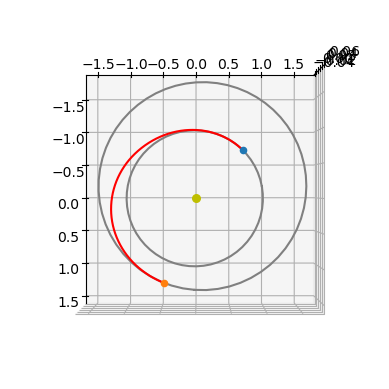

In [28]:
ax3D = udp.plot(pop.champion_x, N=2000)
ax3D.view_init(90, 0)

The throttle is always on as dictated by the PMP as the trajectory is time optimal.

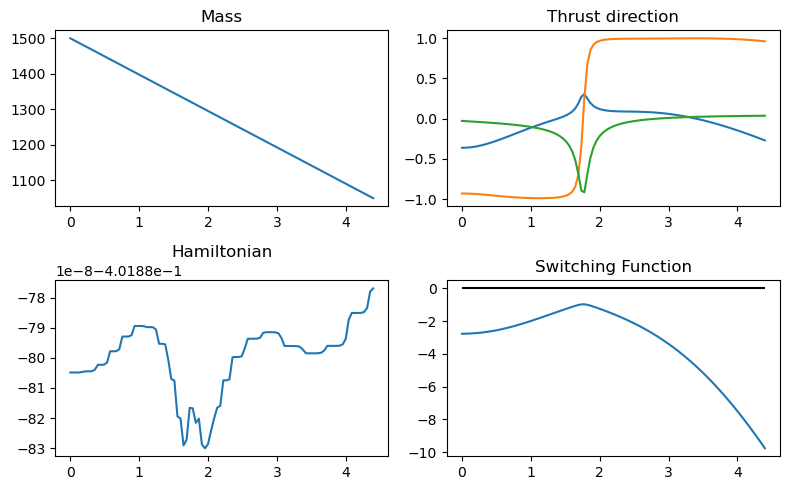

In [18]:
udp.plot_misc(pop.champion_x, figsize = (8,5));

## Homotopy

We now try to use a continuation techniaue on the maximal thrust as to increase the number of revolutions and go towards a very-low-thrust trajectory.

## Exponential homotopy on $T_{max}$
Here we decrease the $T_{max}$ parameter exponentially and use as predictor for the new decision vector corresponding to each successive new value of $T_{max}$, the previous decision vector. This method forces the step size on the epsilon exponential decrease to
small values. 

The following code block implements an exponential homotopy over $\epsilon$.

In [19]:
algo=minpack_g

In [20]:
import time
from copy import deepcopy

# No initial guess
first = True
T_max = 0.6
tof_guess_days = 250
decrease_factor = 0.95

# Solve
while True:
    # Set the current epsilon in the udp and construct a problem 
    # (a copy here will be made, so that the udp inside the prob object
    # is a different udp)
    prob = prob_factory(T_max, tof_guess_days)
    udp = prob.extract(pk.trajopt.pontryagin_cartesian_time)

    # First time looks for a solution, then it continues it
    if first:
        # Creates a random ic population
        pop = pg.population(prob, 1)
        # Starts the time to profile the homotopy time only 
        # (i.e. we exclude the effort to find the first valid traj)
        tstart_tot = time.time()
    else:
        # Use predicted new chromosome
        pop = pg.population(prob)
        pop.push_back(predicted_chromosome)

    # Evolve
    tstart = time.time()
    pop = algo.evolve(pop)
    tend = time.time()

    # Compute constraint violation norm
    err = np.linalg.norm(pop.champion_f[1:])

    # If we find a feasible solution (either the first or a continued one, we log and start the predictor)
    if prob.feasibility_f(pop.champion_f):
        if first:
            # We decrease the number of iterations as to favour quick multistarts
            print("Initial solution found, starting homotopy...                                                                         ")
            #algo=ipopt20
            first = False
        tof_guess_days = pop.champion_x[-1] * udp.TIME * pk.SEC2DAY
        udp.fitness(pop.champion_x)
        print(
            f". Success!! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | T_max = {T_max:.4e} | Tof = {pop.champion_x[-1]*udp.TIME*pk.SEC2DAY:4e} | mass = {udp.ta.state[6]*udp.MASS:.4}"
        , end = "\r", flush=True)

        # Save decision vector for current epsilon (which will be used as an initial guess in the next iteration)
        predicted_chromosome = deepcopy(pop.champion_x)
        best_T_max = T_max

        # Save current epsilon (needed if iteration fails)
        T_max_previous = T_max

        # Decrease epsilon
        T_max = T_max * decrease_factor

        # Stopping condition (desired epsilon reached)
        if T_max < 0.2:
            udp.fitness(pop.champion_x)
            print(
                f". Success!! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | T_max = {T_max:.4e} | Tof = {pop.champion_x[-1]*udp.TIME*pk.SEC2DAY:4e} | mass = {udp.ta.state[6]*udp.MASS:.4}"
            )
            break

    else:
        udp.fitness(pop.champion_x)
        print(
            f"x Failedd!! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | T_max = {T_max:.4e} | Tof = {pop.champion_x[-1]*udp.TIME*pk.SEC2DAY:4e} | mass = {udp.ta.state[6]*udp.MASS:.4}"
        , end = "\r", flush=True)

        # If first iteration fails, try again with different initial guess
        if first:
            pass

        # T_max is too small, we need to increase it (halfway between previous and current)
        else:
            T_max = T_max + abs(T_max_previous - T_max) / 2
tend_tot = time.time()
print(f"Total CPU time: {tend_tot - tstart_tot:.2e}")
# Need to call the fitness once as to use the internal ta in the udp
udp.fitness(pop.champion_x)
print("mass", udp.ta.state[6]*udp.MASS)
print("time", pop.champion_x[-1]*udp.TIME*pk.SEC2DAY)

Initial solution found, starting homotopy...                                                                         
. Success!! | Error: 2.36e-09 | CPU time: 1.67e-02 | T_max = 1.9425e-01 | Tof = 9.172453e+02 | mass = 949.2e+03
Total CPU time: 1.16e+00
mass 949.205127728
time 917.245286538


We could obtain a better total computational time if we could just use a higher exponential decrease factor ... but we cannot as 
the initial guess (the predictor used) is poor, so that we are stuck with this.

Let us plot what we found ...

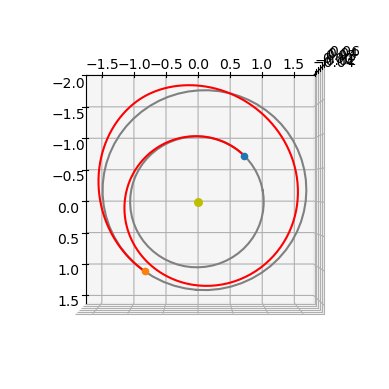

In [21]:
ax3D = udp.plot(pop.champion_x, N=300)
ax3D.view_init(90, 0)

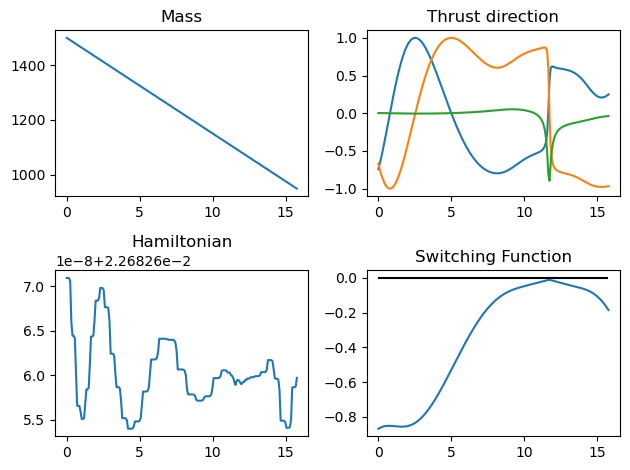

In [22]:
udp.plot_misc(pop.champion_x, N=200);